<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Transfer Learning with Advanced Open-Source Models

## Data Preparation

### Preprocessing Steps

The preprocessing steps have already been completed in the previous stage, which include:
- Dropping duplicates
- Setting data types
- Dropping unnecessary columns
- Tokenizing text data
- Stopword Removal
- Language detection
- Translating non-English text to English
- Lemmatization

These steps were applied to both datasets, `media` and `patents`, and the resulting data was saved in the `data` folder. We will now load the data and perform the following steps:

In [1]:
!pip install evaluate
!pip install cupy-cuda12x --upgrade
!pip install cugraph-cu12 --extra-index-url https://pypi.nvidia.com --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [2]:
# module imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch

print(torch.cuda.is_available())  # Should print True if GPU is present
!nvidia-smi # shows if we're using GPU

# RoBERTa
from transformers import AutoConfig, AutoModelForMaskedLM, AutoModelForSequenceClassification


True
Mon Mar 24 19:42:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   67C    P8             18W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [3]:
from google.colab import drive
drive.mount('/content/drive')

processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

print("Media Backup:")
processed_media_data_backup.head(5)

print("Patent Backup:")
processed_patent_data_backup.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Media Backup:
Patent Backup:


,publication_number,application_number,title,abstract,publication_date,inventor,processed_text
0,US-2022239235-A1,US-202217717397-A,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,2022-07-28 00:00:00,[],Disclosed adaptable DC AC inverter system oper...
1,US-2022239251-A1,US-202217580956-A,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",2022-07-28 00:00:00,[],in accordance example embodiment solar energy ...
2,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum Steuern einer Windenergieanlage ...
3,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum Steuern einer Windenergieanlage ...
4,US-11396827-B2,US-202117606042-A,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,2022-07-26 00:00:00,[],a control method optimize solar power efficien...


### Create training and validation sets for both media and patent texts.

In [4]:
# Function to preprocess data
def preprocess_data(data, seed=42):
	data = shuffle(data, random_state=seed).reset_index(drop=True)  # Shuffle and reset index with seed
	data = data.dropna().drop_duplicates(subset=['processed_text'])  # Drop NaN and duplicates
	return data.reset_index(drop=True)

# Preprocess media and patent data
media_data = preprocess_data(processed_media_data_backup.copy(), seed=42)
patent_data = preprocess_data(processed_patent_data_backup.copy(), seed=42)

# Split the data into training and validation sets with seed
media_train, media_val = train_test_split(media_data, test_size=0.2, random_state=42)
patent_train, patent_val = train_test_split(patent_data, test_size=0.2, random_state=42)

# Display sample data
print("Media Train:")
media_train.head(5) #notice how the index is reset after shuffling

# Display sample data
print("Patent Train:")
patent_train.head(5) #notice how the index is reset after shuffling

Media Train:
Patent Train:


,publication_number,application_number,title,abstract,publication_date,inventor,processed_text
2820,CN-216951658-U,CN-202220124858-U,Main shaft oil seal of hydrogen energy automob...,The utility model discloses a hydrogen energy ...,2022-07-12 00:00:00,[],the utility model disclose hydrogen energy aut...
9016,CN-114693054-A,CN-202111539539-A,水电站运行状态的确定方法、装置、设备及存储介质,"The disclosure provides a method, a device, eq...",2022-07-01 00:00:00,[],the disclosure provide method device equipment...
5682,CN-216615597-U,CN-202122207940-U,一种市政道路桥梁用可调节限高杆,The utility model provides an adjustable heigh...,2022-05-27 00:00:00,[],the utility model provide adjustable height li...
9312,CN-216220680-U,CN-202122393877-U,Foldable commodity shelf,The utility model provides a foldable commodit...,2022-04-08 00:00:00,['Ruan Lingyue'],the utility model provide foldable commodity s...
9298,CN-217031637-U,CN-202123386722-U,Novel plug-in type solar energy collection header,"本实用新型涉及一种新型的插接式太阳能集热联箱，包括内胆和外壳,在内胆和外壳之间设有保温层,集...",2022-07-22 00:00:00,[],在内胆和外壳之间设有保温层 集热联箱的正面沿其长度方向设有若干个安装真空集热管的插孔 真空集...


## Transfer Learning with Advanced Open-Source Models
- Implement transfer learning by fine-tuning pre-trained open-source models such as RoBERTa, XLNet, Longformer, FLAN-T5, and BART on the text data. Evaluate the model performance using intrinsic measures (e.g., word similarity, clustering quality) before and after fine-tuning. Analyze and quantify the insights gained from the fine-tuned model regarding emerging trends and innovation gaps in cleantech.
- Compare the performance of transfer learning with the in-house embeddings.
This comparison could be done through evaluating the effectiveness of the embeddings in domain-specific tasks like topic classification.

### RoBERTa
Is an optimized BERT approach, generally good at capturing domain-specific language. So once we have fine-tuned this, we can better recognize domain jargon.
 It leverages a robust transformer architecture pre-trained on large datasets using masked language modeling. It is also allowing us for downstream tasks suc has clustering or others to discover new insights.

#### Load Model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "roberta-base"

config = AutoConfig.from_pretrained(model_name)

# Patent Data
patent_base_mlm_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
patent_base_mlm_model.to(device)
patent_base_mlm_model.eval()

patent_mlm_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
patent_mlm_model.to(device)
patent_mlm_model.eval()



#Media Data
# fine-tuned model
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
mlm_model.to(device)
mlm_model.eval()

# base model
base_model = AutoModelForMaskedLM.from_pretrained(model_name)
base_model.to(device)
base_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

#### Fine-Tuning

In [ ]:
# Needed to apply the changes below
from datasets import Dataset
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from evaluate import load


Patent Data

In [6]:
hf_patent_train = Dataset.from_pandas(patent_train)
hf_patent_val = Dataset.from_pandas(patent_val)

In [9]:

# --------------------------------------------------
# Load the RoBERTa tokenizer
# --------------------------------------------------
roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)

# --------------------------------------------------
# Define a function to re-join your words and apply RoBERTa subword tokenization
# --------------------------------------------------
def tokenize_roberta(batch):
    # 'processed_text' is a list of individual tokens, e.g. ["renewable", "energy", "innovation"]
    joined_texts = [" ".join(words) for words in batch["processed_text"]]
    return roberta_tokenizer(
        joined_texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

# --------------------------------------------------
# Apply the tokenization to train/val sets
#
# --------------------------------------------------
hf_patent_train = hf_patent_train.map(tokenize_roberta, batched=True)
hf_patent_val   = hf_patent_val.map(tokenize_roberta, batched=True)

# --------------------------------------------------
# Create a data collator specialized for MLM
#    This will randomly mask tokens during training.
# --------------------------------------------------
patent_data_collator = DataCollatorForLanguageModeling(
    tokenizer=roberta_tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# --------------------------------------------------
# Define training arguments
# --------------------------------------------------
patent_training_args = TrainingArguments(
    output_dir="./checkpoints_roberta_mlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=18,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_steps=500,
    save_steps=2000,
)

# --------------------------------------------------
# Build the Trainer
# --------------------------------------------------
patent_trainer = Trainer(
    model=patent_mlm_model,
    args=patent_training_args,
    train_dataset=hf_patent_train,
    eval_dataset=hf_patent_val,
    data_collator=patent_data_collator
)

# --------------------------------------------------
# 8. Fine-tune (Train) the Model
# --------------------------------------------------
patent_trainer.train()
patent_trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model_patent")

Map:   0%|          | 0/8391 [00:00<?, ? examples/s]

Map:   0%|          | 0/2098 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.228827
2,0.370800,0.171870
3,0.212100,0.146442
4,0.172300,0.138298


For the patent data we try 4 epochs instead of 3 due to a smaller dataset compared to media. With overiftting in mind, we can say that based on the training process with Training & Validation loss that overfitting seems not to be the case (we'd expect decreasing training loss while validation loss increases or stagnates or see a training luss muc hlower than validation loss)

Media Data

In [ ]:
hf_train = Dataset.from_pandas(media_train)
hf_val = Dataset.from_pandas(media_val)

In [ ]:
# --------------------------------------------------
# Load the RoBERTa tokenizer
# --------------------------------------------------
roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)

# --------------------------------------------------
# Define a function to re-join your words and apply RoBERTa subword tokenization
# --------------------------------------------------
def tokenize_roberta(batch):
    # 'processed_text' is a list of individual tokens, e.g. ["renewable", "energy", "innovation"]
    joined_texts = [" ".join(words) for words in batch["processed_text"]]
    return roberta_tokenizer(
        joined_texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

# --------------------------------------------------
# Apply the tokenization to train/val sets
#
# --------------------------------------------------
hf_train = hf_train.map(tokenize_roberta, batched=True)
hf_val   = hf_val.map(tokenize_roberta, batched=True)

# --------------------------------------------------
# Create a data collator specialized for MLM
#    This will randomly mask tokens during training.
# --------------------------------------------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=roberta_tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# --------------------------------------------------
# Define training arguments
# --------------------------------------------------
training_args = TrainingArguments(
    output_dir="./checkpoints_roberta_mlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=500,
    save_steps=2000,
)

# --------------------------------------------------
# Build the Trainer
# --------------------------------------------------
trainer = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator
)

# --------------------------------------------------
# 8. Fine-tune (Train) the Model
# --------------------------------------------------
trainer.train()
trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")

Map:   0%|          | 0/16050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.518100,0.410961
2,0.395000,0.323976
3,0.349900,0.299806


Similar as with Patent Data, we see no overfitting given this information of Training and Validation Loss

#### Evaluation and Comparison
**Check Perplexity**
A lower perplexity indicates that our model is better at predicting masked tokens in your domain text.

If perplexity is extremely high (for example > 100), the model is struggling.


In [10]:
import math

In [11]:
def evaluate_and_print(trainer, label):

    eval_results = trainer.evaluate()
    eval_loss = eval_results["eval_loss"]
    perplexity = math.exp(eval_loss)
    print(f"Validation Loss {label}: {eval_loss:.4f}")
    print(f"Validation Perplexity {label}: {perplexity:.4f}")

Base model - Patent Data

In [13]:
base_mlm_trainer_patent = Trainer(
    model=patent_base_mlm_model,
    args=patent_training_args,
    train_dataset=hf_patent_train,
    eval_dataset=hf_patent_val,
    data_collator=patent_data_collator
)

evaluate_and_print(base_mlm_trainer_patent, "Base Patent Data")

Validation Loss Base Patent Data: 1.1796
Validation Perplexity Base Patent Data: 3.2531


Fine-Tuned Model - Patent Data

In [14]:
patent_mlm_model.to(device)
patent_mlm_model.eval()

evaluate_and_print(patent_trainer, "Fine-Tuned Patent Data")

Validation Loss Fine-Tuned Patent Data: 0.1368
Validation Perplexity Fine-Tuned Patent Data: 1.1466


Interpretation Patent Data:

The base model shows a much higher validation loss (1.1796) and perplexity (3.2531) on the patent data, indicating it struggles to predict the masked tokens accurately in this specialized domain. In contrast, the fine-tuned model achieves a very low validation loss (0.1368) and perplexity (1.1466), demonstrating that it has learned the domain-specific vocabulary and context much better. This significant improvement suggests that fine-tuning on patent data has made the model far more confident and effective at handling cleantech patent language.

 Base Model - Media Data

In [ ]:
base_trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator
)


evaluate_and_print(base_trainer, "Base Media Data")


Validation Loss: 1.6778
Validation Perplexity: 5.3535


Fine-tuned Model - Media Data

In [ ]:
mlm_model.to(device)
mlm_model.eval()

evaluate_and_print(base_trainer, "Fine-Tuned Media Data")

Validation Loss: 0.2967
Validation Perplexity: 1.3454


Interpretation Media Data:

Comparing the base model with the fine-tuned model indicates already remarkable differences.

Results for the fine tuned model are quite good and indicate that our masked language model is confident and accurate in predicting masked tokens on our domain text.
On a previous fine tuning with max token length of 256 and 2 epochs, we had a validation loss of around 0.42. So we have improved this by quite a lot indicating that the model is making fewers errors in its predictions during masked language modelling.

**Definitions**

We use some functions to reduce code duplication

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_word_embedding(text: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the model for a single word or phrase.

    Note: For AutoModelForMaskedLM, we request output_hidden_states=True.
    For AutoModel, the output already contains last_hidden_state.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Request hidden states from the model.
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]    # final layer
        embedding = last_hidden_state[0, 0, :]     # use the [CLS] token

    return embedding

def get_embeddings_for_terms(terms, tokenizer, model, device):
    embeddings = {}
    for term in terms:
        embeddings[term] = get_word_embedding(term, tokenizer, model, device)
    return embeddings

def visualize_embeddings(embeddings, title_suffix="", k=5):
    terms = list(embeddings.keys())

    # ----- A) Pairwise Similarities (printed) -----
    print("Pairwise Cosine Similarities:\n")
    for t1 in terms:
        for t2 in terms:
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )
            print(f"Similarity({t1}, {t2}) = {sim.item():.4f}")
        print()  # add a new line after each row


    # ----- B) Similarity Matrix Heatmap -----
    n = len(terms)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    for i, t1 in enumerate(terms):
        for j, t2 in enumerate(terms):
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )
            similarity_matrix[i, j] = sim.item()

    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(terms, rotation=45, ha='right')
    ax.set_yticklabels(terms)
    ax.set_title("Cosine Similarity Matrix " + title_suffix)
    plt.tight_layout()
    plt.show()

    # ----- C) Convert embeddings to 2D NumPy array -----
    vectors = []
    for w in terms:
        emb = embeddings[w]
        if emb.is_cuda:
            emb = emb.cpu()
        vectors.append(emb.numpy())
    vectors_np = np.stack(vectors, axis=0)  # shape: [num_terms, embedding_dim]

    # ----- D) Knee (Elbow) Plot for K-Means Inertia -----
    ks = list(range(2, 11))  # testing cluster numbers 2 to 10
    inertias = []
    for k_val in ks:
        kmeans_temp = KMeans(n_clusters=k_val, random_state=42)
        kmeans_temp.fit(vectors_np)
        inertias.append(kmeans_temp.inertia_)

    plt.figure(figsize=(6, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow/Knee Plot " + title_suffix)
    plt.xticks(ks)
    plt.show()

    # ----- E) PCA Visualization -----
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("PCA of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- F) t-SNE Visualization -----
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    tsne_2d = tsne.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = tsne_2d[i, 0], tsne_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("t-SNE of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- G) K-Means Clustering & Silhouette Score -----
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_np)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(vectors_np, cluster_labels)
    print(f"K-Means (k={k}) Silhouette Score {title_suffix}: {sil_score:.4f}")

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, c=f"C{cluster_labels[i]}")
        plt.annotate(w, (x, y))
    plt.title(f"K-Means Clustering (k={k}) {title_suffix}\nSilhouette: {sil_score:.3f}")
    plt.show()

##### Load models
This section contains some duplication from above but can be used as starting point to not have to train the models again for hours

In [27]:
model_name = "roberta-base"

# Load the fine-tuned MLM model (assume you already fine-tuned it)
from transformers import AutoModelForMaskedLM, AutoModel, AutoTokenizer, AutoConfig
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer


##Patent Data
patent_mlm_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model_patent")
patent_mlm_model.to(device)
patent_mlm_model.eval()

patent_base_mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)
patent_base_mlm_model.to(device)
patent_base_mlm_model.eval()


## Media Data

# Fine-tuned model:
mlm_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")
# Base model:
base_model = AutoModelForMaskedLM.from_pretrained(model_name)



roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlm_model.to(device)
base_model.to(device)
mlm_model.eval()
base_model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

##### Word Similarity and Clustering Quality
In this section, we use single terms and complete sentences to check for their similarity and how well they can be clustered.

In [28]:
# -----------------------------
# Define the terms to compare
# -----------------------------
domain_terms = ["hydrogen", "solar", "battery", "wind", "ammonia", "oil", "nuclear", "electric", "environment", "water", "fire", "engine", "river",     "abatement",

    # "climate",
    # "cogeneration",
    # "hydrosphere",
    # "incineration",
    # "inorganic",
    # "lifecycle",
    # "natural",
    # "organic",
    # "oxidation",
    # "ozone",
    # "pipeline",
    # "plastic",
    # "pollution"
   ]

Patent Data

In [29]:
# -----------------------------
# Calculate embeddings for each model
# -----------------------------
print("Computing embeddings with Base Model...")
patent_embeddings_base = get_embeddings_for_terms(domain_terms, roberta_tokenizer, patent_base_mlm_model, device)

print("Computing embeddings with Fine-Tuned Model...")
patent_embeddings_finetuned = get_embeddings_for_terms(domain_terms, roberta_tokenizer, patent_mlm_model, device)

Computing embeddings with Base Model...
Computing embeddings with Fine-Tuned Model...



=== Results from Base Model for Patent Data ===
Pairwise Cosine Similarities:

Similarity(hydrogen, hydrogen) = 1.0000
Similarity(hydrogen, solar) = 0.9993
Similarity(hydrogen, battery) = 0.9993
Similarity(hydrogen, wind) = 0.9990
Similarity(hydrogen, ammonia) = 0.9992
Similarity(hydrogen, oil) = 0.9992
Similarity(hydrogen, nuclear) = 0.9991
Similarity(hydrogen, electric) = 0.9992
Similarity(hydrogen, environment) = 0.9991
Similarity(hydrogen, water) = 0.9990
Similarity(hydrogen, fire) = 0.9990
Similarity(hydrogen, engine) = 0.9989
Similarity(hydrogen, river) = 0.9993
Similarity(hydrogen, abatement) = 0.9989

Similarity(solar, hydrogen) = 0.9993
Similarity(solar, solar) = 1.0000
Similarity(solar, battery) = 0.9994
Similarity(solar, wind) = 0.9991
Similarity(solar, ammonia) = 0.9992
Similarity(solar, oil) = 0.9993
Similarity(solar, nuclear) = 0.9992
Similarity(solar, electric) = 0.9994
Similarity(solar, environment) = 0.9991
Similarity(solar, water) = 0.9989
Similarity(solar, fire) = 0

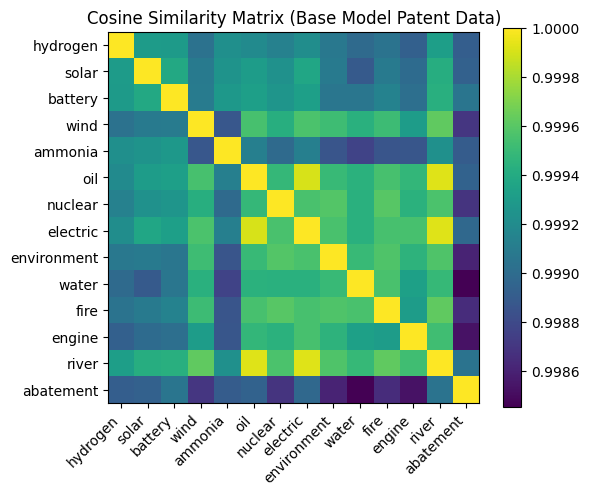

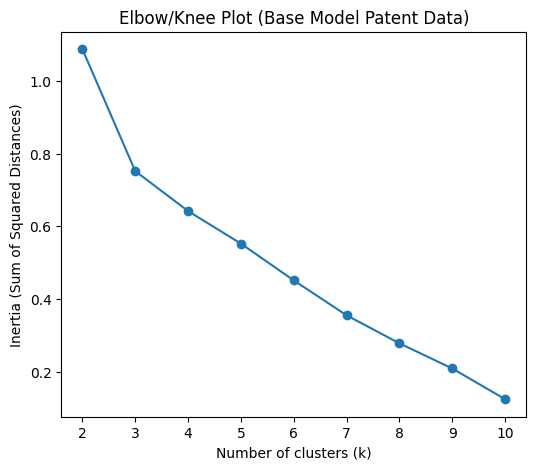

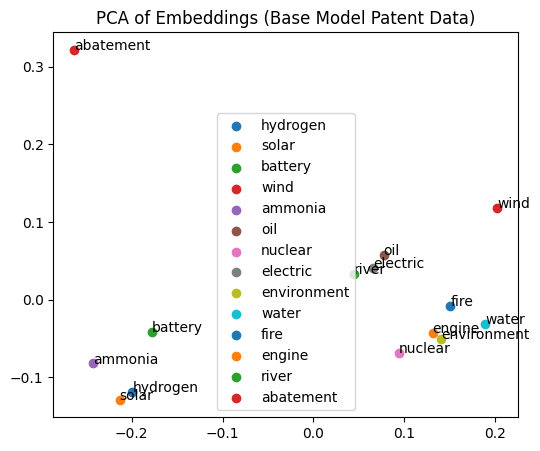

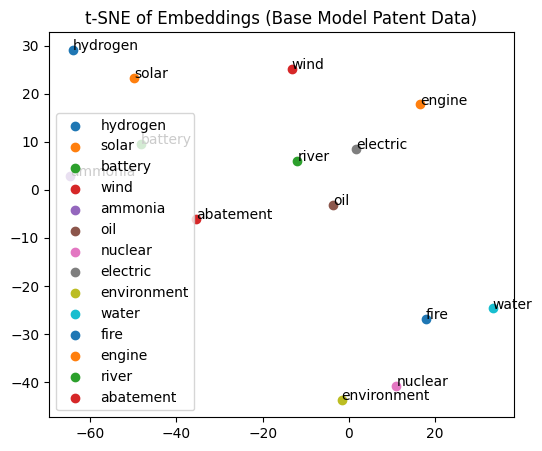

K-Means (k=3) Silhouette Score (Base Model Patent Data): 0.2325


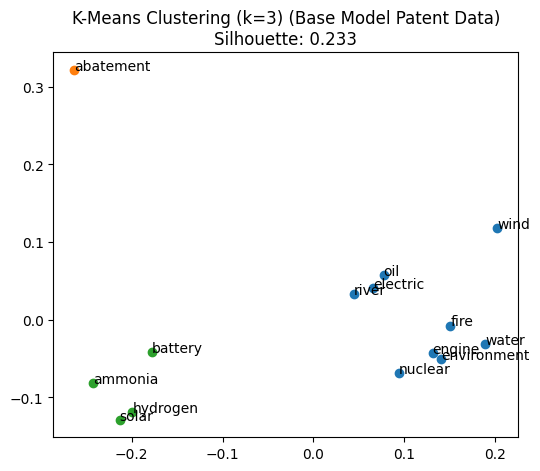

In [30]:
n_clusters = 3 #can be adapted based on the elbow-plot below
# -----------------------------
# 7. Visualize and compare results for the Base Model
# -----------------------------
print("\n=== Results from Base Model for Patent Data ===")
visualize_embeddings(patent_embeddings_base, title_suffix="(Base Model Patent Data)", k=n_clusters)


=== Results from Fine-Tuned Model ===
Pairwise Cosine Similarities:

Similarity(hydrogen, hydrogen) = 1.0000
Similarity(hydrogen, solar) = 0.9994
Similarity(hydrogen, battery) = 0.9994
Similarity(hydrogen, wind) = 0.9990
Similarity(hydrogen, ammonia) = 0.9993
Similarity(hydrogen, oil) = 0.9992
Similarity(hydrogen, nuclear) = 0.9992
Similarity(hydrogen, electric) = 0.9993
Similarity(hydrogen, environment) = 0.9992
Similarity(hydrogen, water) = 0.9989
Similarity(hydrogen, fire) = 0.9989
Similarity(hydrogen, engine) = 0.9993
Similarity(hydrogen, river) = 0.9993
Similarity(hydrogen, abatement) = 0.9988

Similarity(solar, hydrogen) = 0.9994
Similarity(solar, solar) = 1.0000
Similarity(solar, battery) = 0.9996
Similarity(solar, wind) = 0.9992
Similarity(solar, ammonia) = 0.9992
Similarity(solar, oil) = 0.9993
Similarity(solar, nuclear) = 0.9993
Similarity(solar, electric) = 0.9994
Similarity(solar, environment) = 0.9993
Similarity(solar, water) = 0.9990
Similarity(solar, fire) = 0.9991
Simi

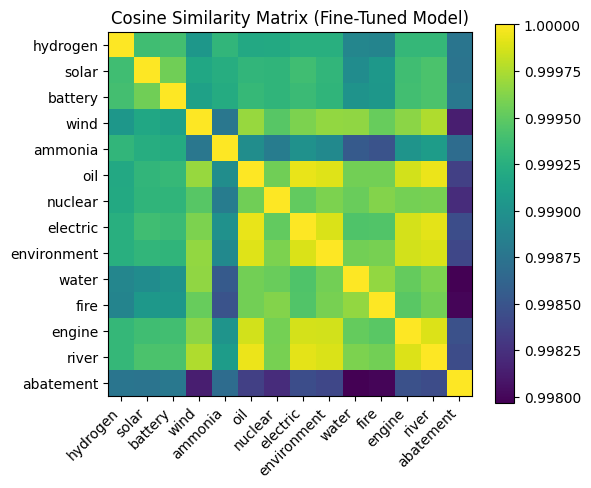

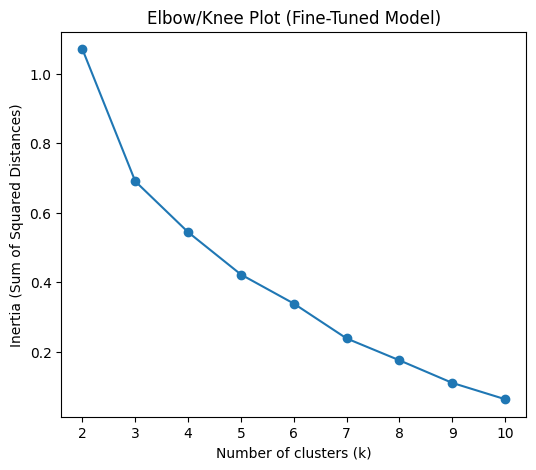

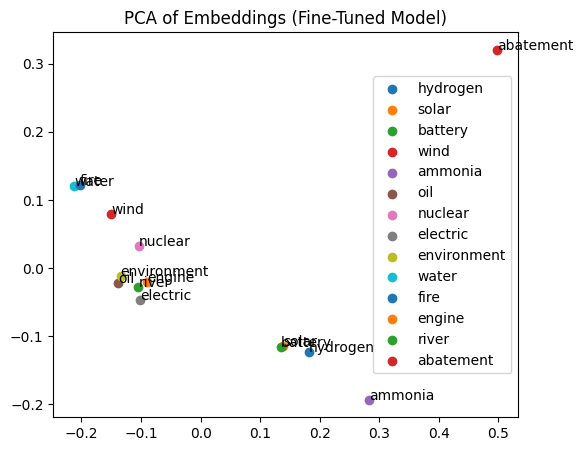

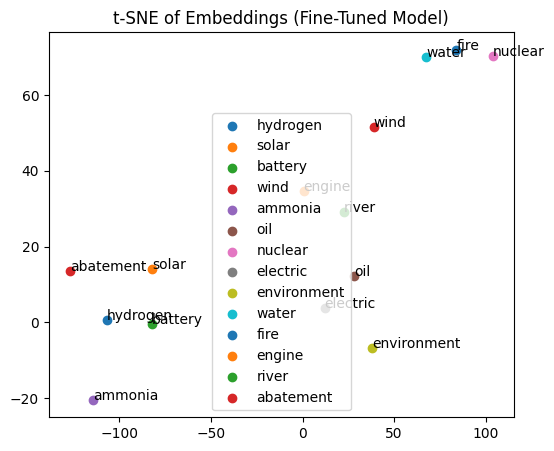

K-Means (k=3) Silhouette Score (Fine-Tuned Model): 0.2857


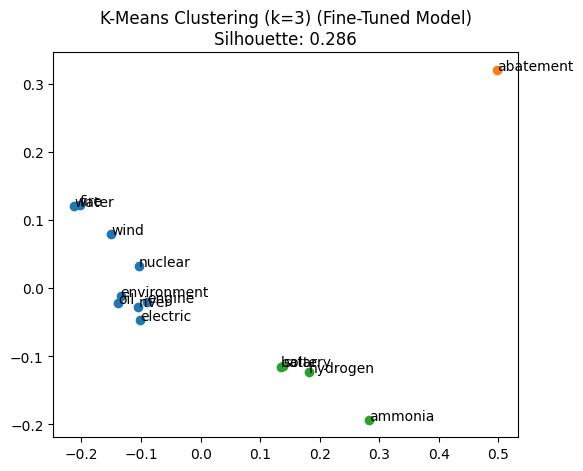

In [31]:
# -----------------------------
# 8. Visualize and compare results for the Fine-Tuned Model
# -----------------------------
print("\n=== Results from Fine-Tuned Model ===")
visualize_embeddings(patent_embeddings_finetuned, title_suffix="(Fine-Tuned Model)", k=n_clusters)

Compared to the base model, the fine-tuned model produces more distinct clusters in both PCA and t-SNE visualizations, indicating it better captures semantic differences among patent-related terms. The slight increase in silhouette score (0.233 compared to 0.286) also suggests that the fine-tuned model forms more coherent groupings. In the cosine similarity matrices, the fine-tuned model shows more pronounced off-diagonal variations, implying it has learned domain-specific relationships that the base model treats as nearly identical. Overall, the fine-tuned model demonstrates an improved understanding of patent terminology and themes, making it more capable of distinguishing subtle nuances in the cleantech patent space.

Media Data

In [32]:
# -----------------------------
# Calculate embeddings for each model
# -----------------------------
print("Computing embeddings with Base Model...")
embeddings_base = get_embeddings_for_terms(domain_terms, roberta_tokenizer, base_model, device)

print("Computing embeddings with Fine-Tuned Model...")
embeddings_finetuned = get_embeddings_for_terms(domain_terms, roberta_tokenizer, mlm_model, device)

Computing embeddings with Base Model...
Computing embeddings with Fine-Tuned Model...



=== Results from Base Model ===
Pairwise Cosine Similarities:

Similarity(hydrogen, hydrogen) = 1.0000
Similarity(hydrogen, solar) = 0.9993
Similarity(hydrogen, battery) = 0.9993
Similarity(hydrogen, wind) = 0.9990
Similarity(hydrogen, ammonia) = 0.9992
Similarity(hydrogen, oil) = 0.9992
Similarity(hydrogen, nuclear) = 0.9991
Similarity(hydrogen, electric) = 0.9992
Similarity(hydrogen, environment) = 0.9991
Similarity(hydrogen, water) = 0.9990
Similarity(hydrogen, fire) = 0.9990
Similarity(hydrogen, engine) = 0.9989
Similarity(hydrogen, river) = 0.9993
Similarity(hydrogen, abatement) = 0.9989

Similarity(solar, hydrogen) = 0.9993
Similarity(solar, solar) = 1.0000
Similarity(solar, battery) = 0.9994
Similarity(solar, wind) = 0.9991
Similarity(solar, ammonia) = 0.9992
Similarity(solar, oil) = 0.9993
Similarity(solar, nuclear) = 0.9992
Similarity(solar, electric) = 0.9994
Similarity(solar, environment) = 0.9991
Similarity(solar, water) = 0.9989
Similarity(solar, fire) = 0.9991
Similarity

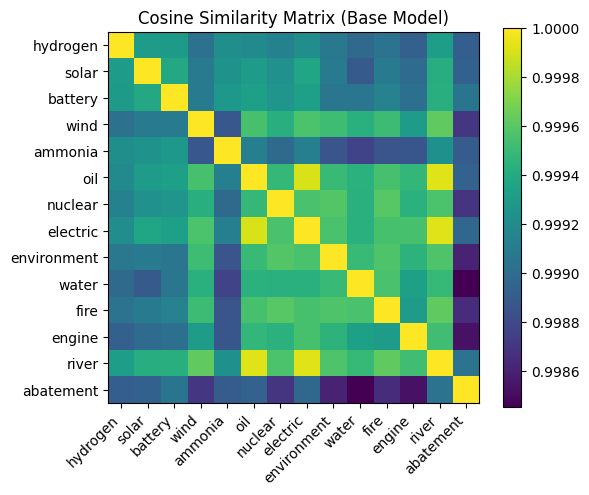

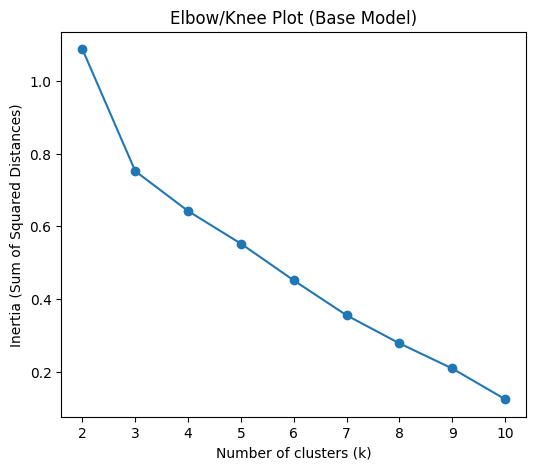

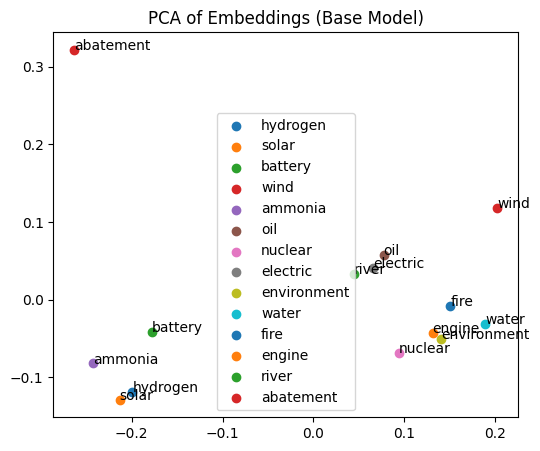

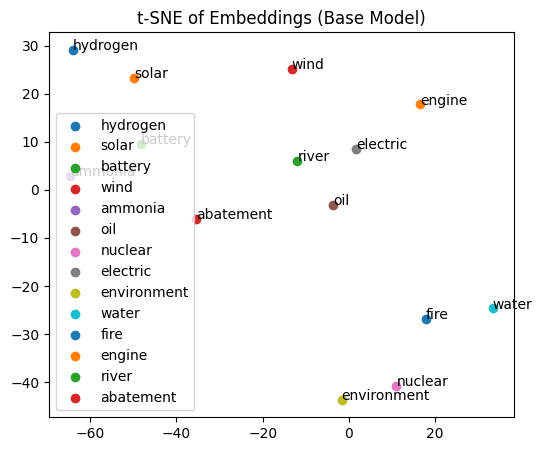

K-Means (k=3) Silhouette Score (Base Model): 0.2325


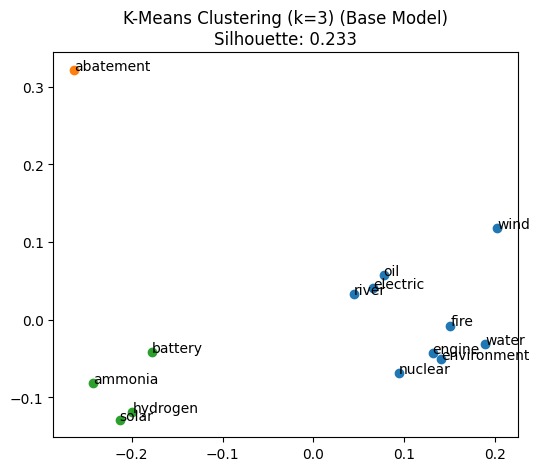

In [33]:
n_clusters = 3 #can be adapted based on the elbow-plot below
# -----------------------------
# 7. Visualize and compare results for the Base Model
# -----------------------------
print("\n=== Results from Base Model ===")
visualize_embeddings(embeddings_base, title_suffix="(Base Model)", k=n_clusters)

As it can be seen here, each word pair has a similarity of almost 1 which means that our model is not differentiating single-word inputs very much. However, we check the visualisation for further information ...

After plotting the single-word embeddings of ["hydrogen", "solar", "battery", "wind", "ammonia", "oil"], we see:

1. **Distinct Positions in 2D**  
   - Even though we observed extremely high cosine similarities (≥ 0.999) among all tokens in their native high-dimensional space, these 2D projections reveal each token is placed uniquely.  
   - This indicates the model does encode subtle distinctions at the single-token level, even if they look numerically very close in 768-dimensional space (typical for RoBERTa/BERT).

2. **Differences Between PCA and t-SNE**  
   - **PCA** is a linear method. It uncovers principal directions of variance, so words like “hydrogen”, “ammonia”, or “wind” spread out along different axes.  
   - **t-SNE** is non-linear and focuses on preserving local distances, which can lead to a very different layout. For instance, “ammonia” and “wind” might appear far apart in t-SNE because the algorithm emphasizes clustering details differently than PCA.

3. **Why the Embeddings Seem Close Yet Plotted Apart**  
   - High cosine similarity for single tokens indicates minimal variation in the final-layer vector. But **tiny differences in 768D** can become amplified when projected to 2D.  
   - Additionally, t-SNE doesn’t map distance 1-to-1 with cosine; it tries to place similar points together while spreading out dissimilar points, sometimes exaggerating separation for clarity.

In summary, **both visualizations confirm** there is some inherent semantic distinction in how the model represents these energy-related terms, but single-token embeddings remain very close overall—particularly in the final layer specialized for masked language modeling.


=== Results from Fine-Tuned Model ===
Pairwise Cosine Similarities:



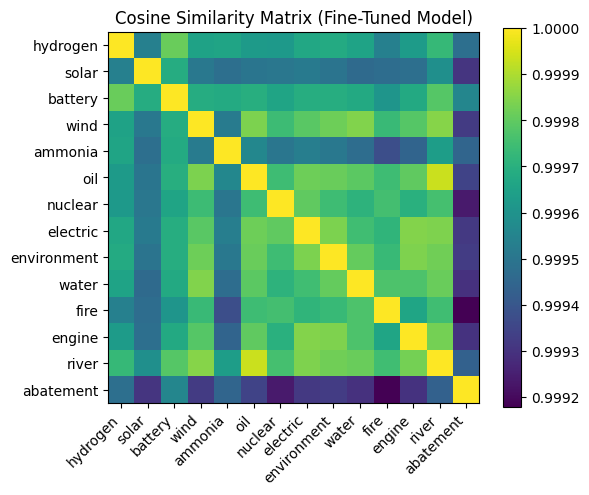

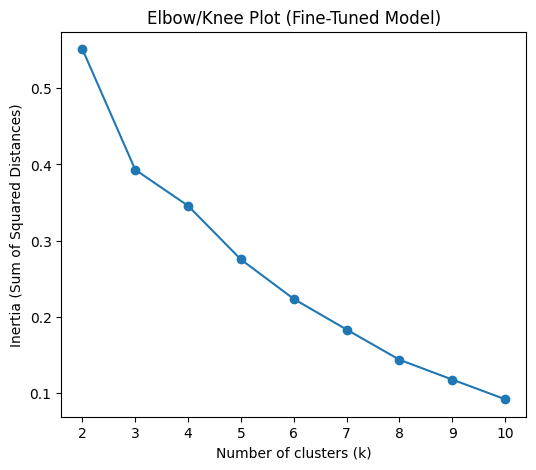

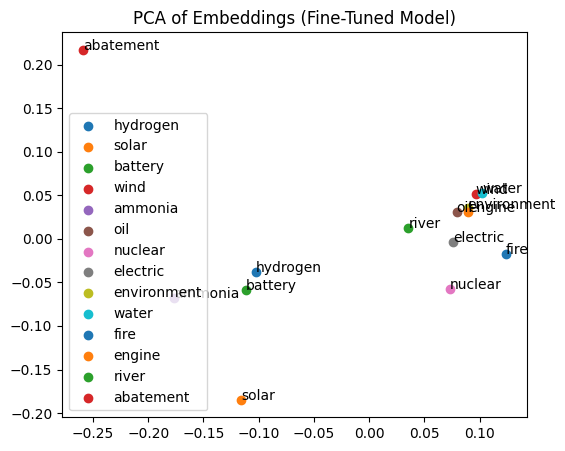

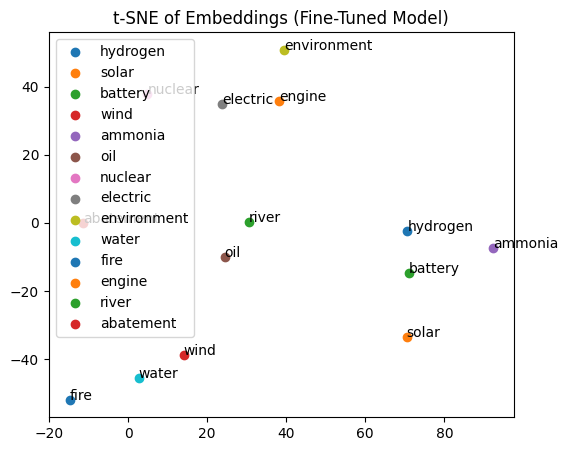

K-Means (k=3) Silhouette Score (Fine-Tuned Model): 0.2164


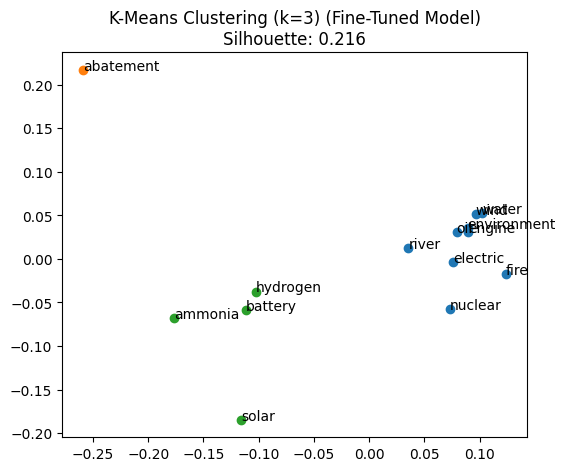

In [ ]:
# -----------------------------
# 8. Visualize and compare results for the Fine-Tuned Model
# -----------------------------
print("\n=== Results from Fine-Tuned Model ===")
visualize_embeddings(embeddings_finetuned, title_suffix="(Fine-Tuned Model)", k=n_clusters)

If we compare the fine-tuned model with the base model on the media dataset, we see that the base model performs slightly better in clustering words. However, both models perform insufficiently to say that these are acceptable clusters

**Sentences**


In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_sentence_embedding(sentence: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the model for a given sentence/phrase.

    For AutoModelForMaskedLM, we request output_hidden_states=True.
    For AutoModel, the output might already contain last_hidden_state.
    """
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]  # final layer
        embedding = last_hidden_state[0, 0, :] # use the [CLS] token

    return embedding

def get_embeddings_for_sentences(sentences, tokenizer, model, device):
    """
    Returns a dictionary {sentence: embedding_tensor}
    """
    embeddings = {}
    for sent in sentences:
        embeddings[sent] = get_sentence_embedding(sent, tokenizer, model, device)
    return embeddings

def visualize_sentence_embeddings(embeddings, title_suffix="", k=5):
    """
    1) Prints pairwise similarities
    2) Creates a similarity heatmap
    3) Generates an elbow (knee) plot for K-Means
    4) Visualizes embeddings with PCA & t-SNE
    5) Clusters them with K-Means and reports silhouette score
    """
    # Convert dict keys to a list for consistent ordering
    sentences = list(embeddings.keys())

    # A) Print pairwise similarities
    print("Pairwise Cosine Similarities:\n")
    for s1 in sentences:
        for s2 in sentences:
            sim = F.cosine_similarity(
                embeddings[s1].unsqueeze(0),
                embeddings[s2].unsqueeze(0)
            )

    # B) Build similarity matrix
    n = len(sentences)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    for i, s1 in enumerate(sentences):
        for j, s2 in enumerate(sentences):
            sim = F.cosine_similarity(
                embeddings[s1].unsqueeze(0),
                embeddings[s2].unsqueeze(0)
            )
            similarity_matrix[i, j] = sim.item()

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    # Truncate long sentences for axis labels
    ax.set_xticklabels([s[:20] + "..." for s in sentences], rotation=45, ha='right')
    ax.set_yticklabels([s[:20] + "..." for s in sentences])
    ax.set_title("Cosine Similarity Matrix " + title_suffix)
    plt.tight_layout()
    plt.show()

    # C) Convert embeddings to a 2D NumPy array
    vectors = []
    for s in sentences:
        emb = embeddings[s]
        if emb.is_cuda:
            emb = emb.cpu()
        vectors.append(emb.numpy())
    vectors_np = np.stack(vectors, axis=0)

    # D) K-Means Elbow (Knee) Plot
    max_k = min(10,n)
    ks = list(range(2, max_k+1))  # testing cluster numbers from 2..10
    inertias = []
    for k_val in ks:
        kmeans_temp = KMeans(n_clusters=k_val, random_state=42)
        kmeans_temp.fit(vectors_np)
        inertias.append(kmeans_temp.inertia_)

    plt.figure(figsize=(6, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow/Knee Plot " + title_suffix)
    plt.xticks(ks)
    plt.show()

    # E) PCA Visualization
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, label=s[:20] + "...")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title("PCA of Sentence Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # F) t-SNE Visualization
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    tsne_2d = tsne.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = tsne_2d[i, 0], tsne_2d[i, 1]
        plt.scatter(x, y, label=s[:20] + "...")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title("t-SNE of Sentence Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # G) K-Means Clustering & Silhouette Score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_np)
    cluster_labels = kmeans.labels_
    sil = silhouette_score(vectors_np, cluster_labels)
    print(f"K-Means (k={k}) Silhouette Score {title_suffix}: {sil:.4f}")

    # Optional cluster color overlay on PCA
    plt.figure(figsize=(6, 5))
    for i, s in enumerate(sentences):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, c=f"C{cluster_labels[i]}")
        plt.annotate(s[:20] + "...", (x, y))
    plt.title(f"K-Means Clustering (k={k}) {title_suffix}\nSilhouette: {sil:.3f}")
    plt.show()

In [42]:
# Uncomment additional sentences if you want to see different results
domain_sentences = [
    "Hydrogen fuel cells are a promising technology for clean transportation.",
    "Solar energy can be harnessed efficiently with photovoltaic panels.",
    "Battery storage solutions are crucial for renewable energy integration.",
    "Wind farms generate electricity using powerful turbines.",
    "Ammonia is emerging as a potential carbon-free fuel.",
    "Nuclear power remains a contentious yet low-carbon energy source.",
    "Electric vehicles reduce emissions compared to combustion engines.",
    "Environmental regulations aim to limit greenhouse gas emissions.",
 "Hydrogen fuel cells promise efficient and zero-emission energy conversion.",
    "Solar power is becoming more cost-effective as technology improves.",
    "Wind energy harnesses natural air currents to generate electricity.",
    "Battery storage systems are critical for balancing renewable energy supply and demand.",
    # "Ammonia is emerging as a potential hydrogen carrier for clean energy applications.",
    # "Oil companies are increasingly investing in renewable energy projects.",
    # "Nuclear power offers a low-carbon alternative to fossil fuels despite safety concerns.",
    # "Electric vehicles are transforming the transportation sector with reduced emissions.",
    # "Environmental regulations drive innovation in green technologies.",
    # "Geothermal energy provides a stable and renewable heat source for power generation.",
    # "Biofuel production from algae offers a sustainable alternative to fossil fuels.",
    # "Smart grids enable efficient distribution of renewable energy.",
    # "Energy efficiency improvements in buildings reduce overall consumption.",
    # "Carbon capture and storage technologies help mitigate greenhouse gas emissions.",
    # "Waste-to-energy plants convert municipal waste into useful electricity.",
    # "Hydroelectric power plants generate electricity using river water flow.",
    # "Distributed renewable energy systems empower local communities.",
    # "Solar thermal collectors capture heat for industrial processes.",
    # "Electric vehicle charging infrastructure is expanding rapidly.",
    # "Energy storage innovations are critical for integrating variable renewable sources.",
    # "Offshore wind farms harness stronger and more consistent winds.",
    # "Green hydrogen production uses renewable energy to electrolyze water.",
    # "LED lighting technologies offer significant energy savings.",
    # "Sustainable agriculture practices reduce energy usage in food production.",
    # "Urban planning can promote energy-efficient transportation and building design.",
    # "Recycling programs contribute to resource conservation and energy savings.",
    # "Advancements in fuel cell technology are driving cleaner power generation.",
    # "Solar panel efficiency continues to improve through research and development.",
    # "Wind turbine designs are becoming more efficient and resilient.",
    # "Battery recycling is essential for sustainable energy storage solutions.",
    # "Smart meters help consumers monitor and reduce their energy consumption.",
    # "Electric public transportation systems reduce urban air pollution.",
    # "Green building certifications promote environmentally friendly construction practices.",
    # "Rooftop solar installations are growing in popularity in urban areas.",
    # "Energy policies play a key role in accelerating the transition to renewables.",
    # "Innovations in renewable energy technology are crucial for a sustainable future.",
    # "Distributed energy resources allow for a decentralized power grid.",
    # "Renewable energy projects create jobs and stimulate local economies.",
    # "Advanced materials improve the efficiency of solar and wind systems.",
    # "Climate change mitigation efforts rely on rapid adoption of clean energy solutions."
]


Patent Data

In [43]:
# Compute embeddings using the base model for sentences
print("Computing embeddings with Base Model for sentences...")
patent_embeddings_base_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, patent_base_mlm_model, device)

# Compute embeddings using the fine-tuned model for sentences
print("Computing embeddings with Fine-Tuned Model for sentences...")
patent_embeddings_finetuned_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, patent_mlm_model, device)

Computing embeddings with Base Model for sentences...
Computing embeddings with Fine-Tuned Model for sentences...



=== Results from Base Model (Sentences) ===
Pairwise Cosine Similarities:



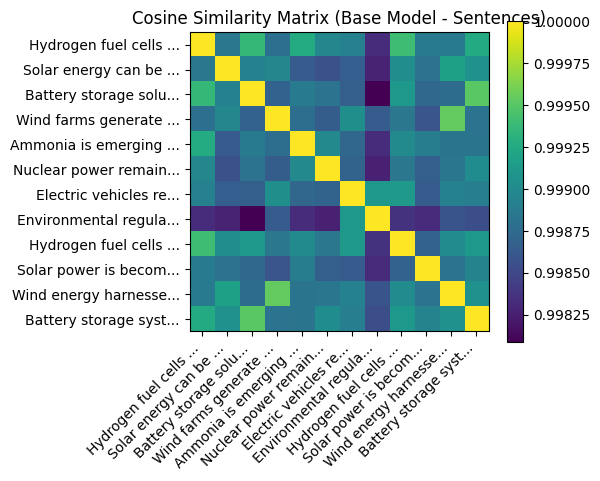

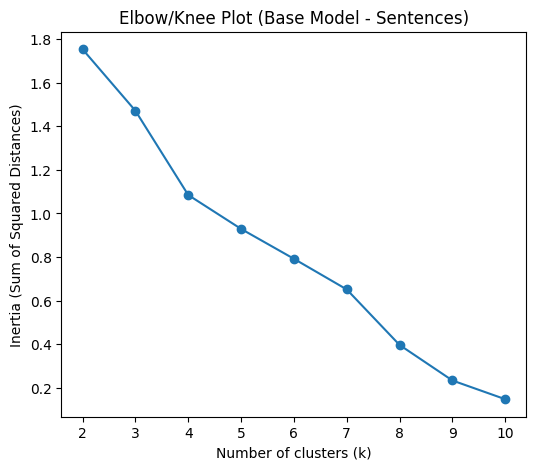

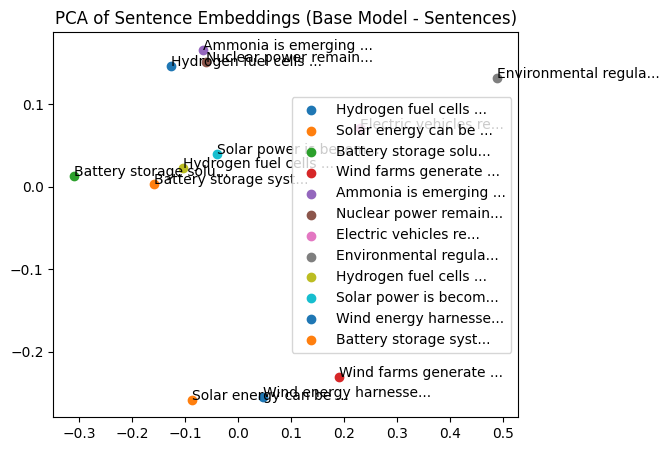

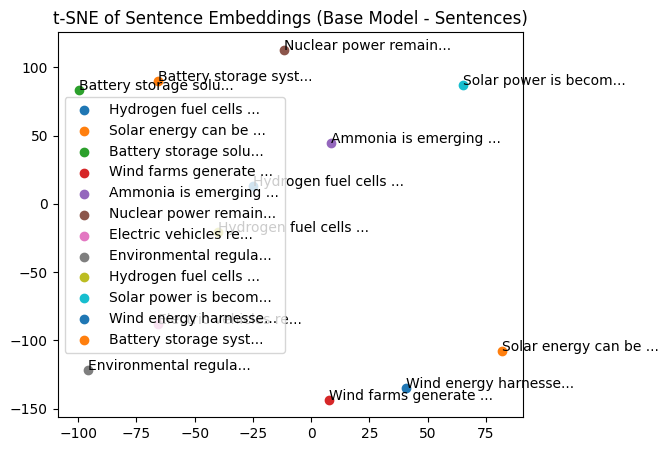

K-Means (k=4) Silhouette Score (Base Model - Sentences): 0.0679


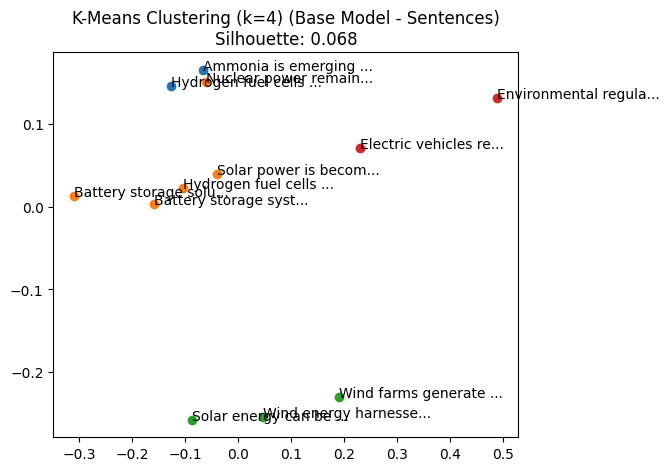

In [46]:
# Set number of clusters for K-Means clustering (based on visualisation that will show it when executing code below)
n_clusters = 4

# Visualize and compare results for the base model
print("\n=== Results from Base Model (Sentences) ===")
visualize_sentence_embeddings(patent_embeddings_base_sentences, title_suffix="(Base Model - Sentences)", k=n_clusters)



=== Results from Fine-Tuned Model (Sentences) ===
Pairwise Cosine Similarities:



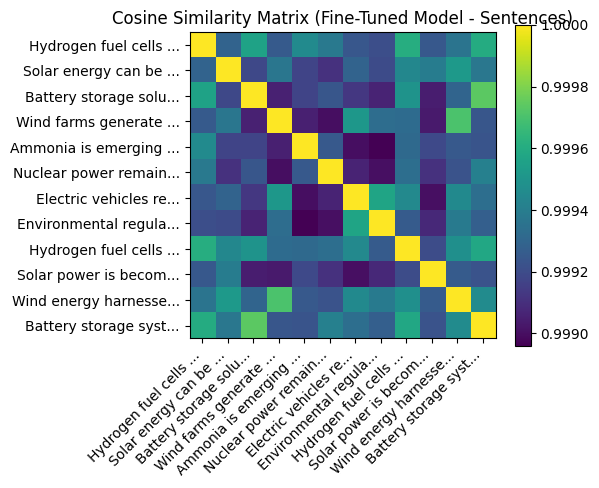

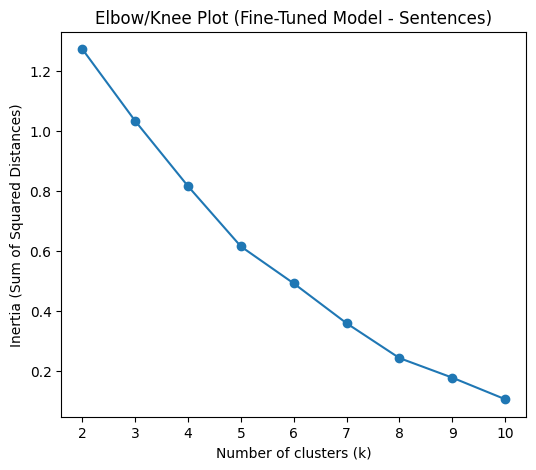

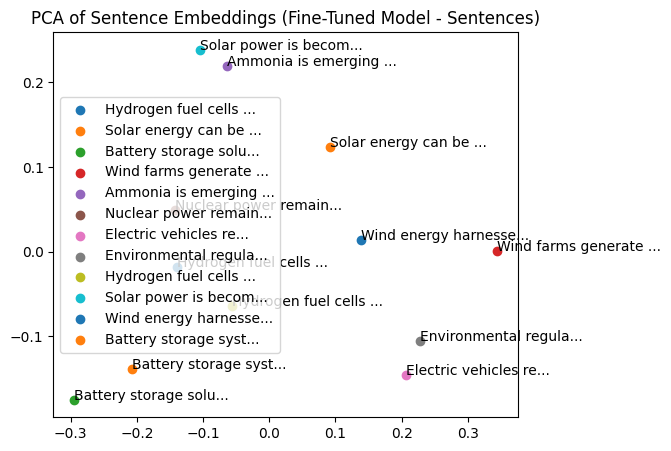

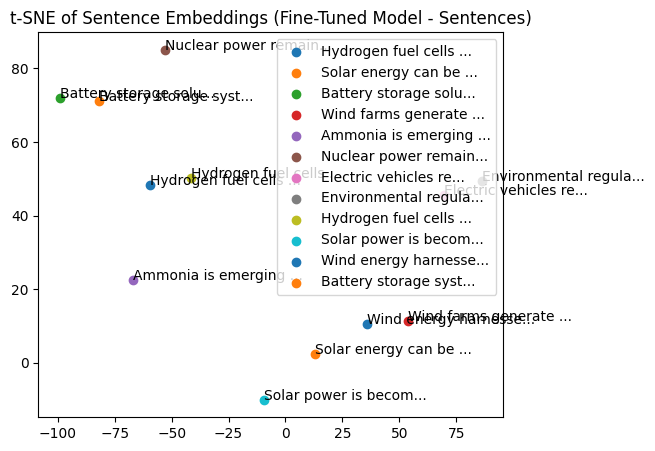

K-Means (k=4) Silhouette Score (Fine-Tuned Model - Sentences): 0.0893


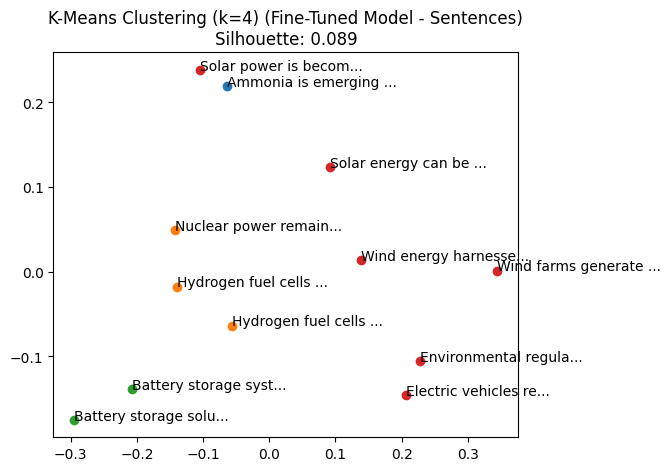

In [47]:
# Visualize and compare results for the fine-tuned model
print("\n=== Results from Fine-Tuned Model (Sentences) ===")
visualize_sentence_embeddings(patent_embeddings_finetuned_sentences, title_suffix="(Fine-Tuned Model - Sentences)", k=n_clusters)

Media Data

In [ ]:
# Compute embeddings using the base model for sentences
print("Computing embeddings with Base Model for sentences...")
embeddings_base_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, base_model, device)

# Compute embeddings using the fine-tuned model for sentences
print("Computing embeddings with Fine-Tuned Model for sentences...")
embeddings_finetuned_sentences = get_embeddings_for_sentences(domain_sentences, roberta_tokenizer, mlm_model, device)


=== Results from Base Model (Sentences) ===
Pairwise Cosine Similarities:



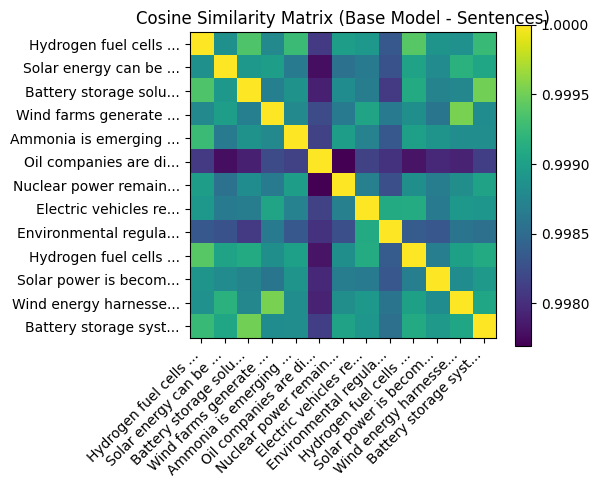

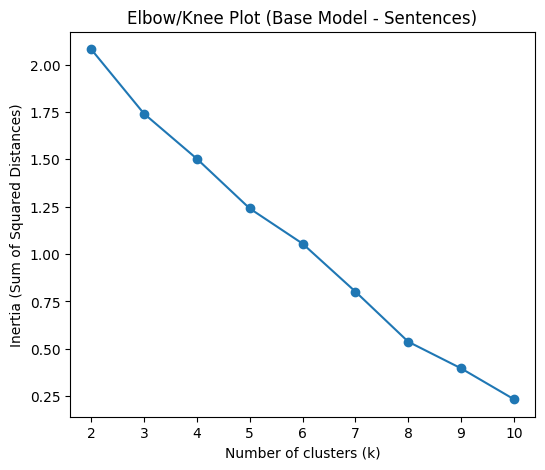

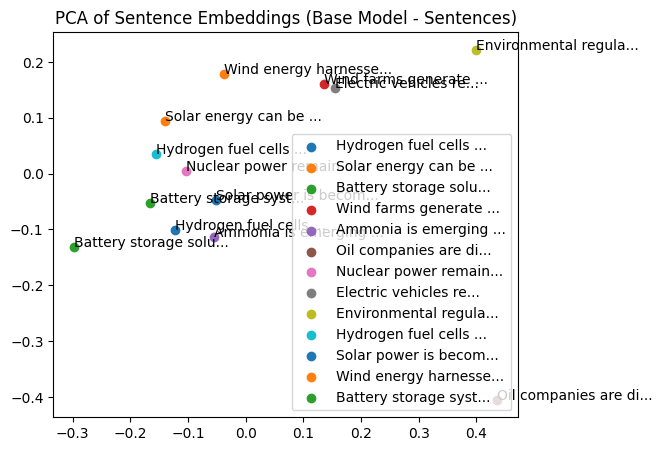

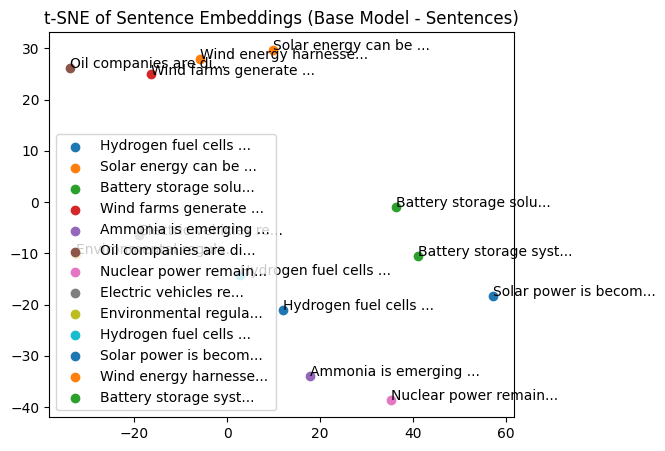

K-Means (k=4) Silhouette Score (Base Model - Sentences): -0.0024


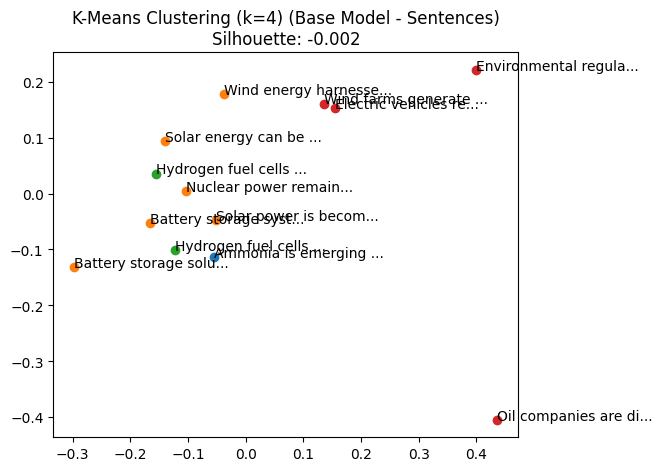

In [ ]:
# Set number of clusters for K-Means clustering (based on visualisation that will show it when executing code below)
n_clusters = 4

# Visualize and compare results for the base model
print("\n=== Results from Base Model (Sentences) ===")
visualize_sentence_embeddings(embeddings_base_sentences, title_suffix="(Base Model - Sentences)", k=n_clusters)



=== Results from Fine-Tuned Model (Sentences) ===
Pairwise Cosine Similarities:



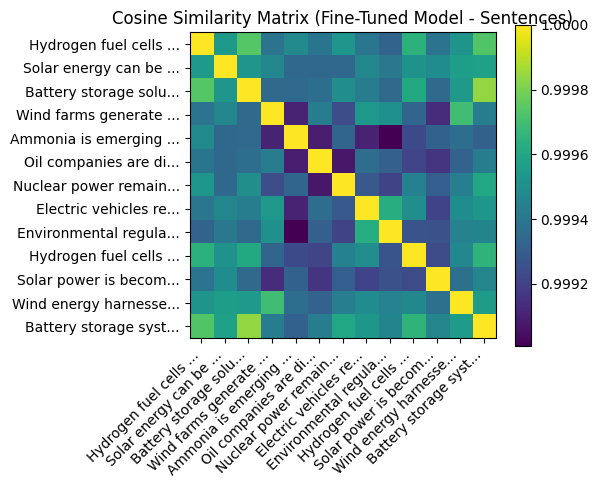

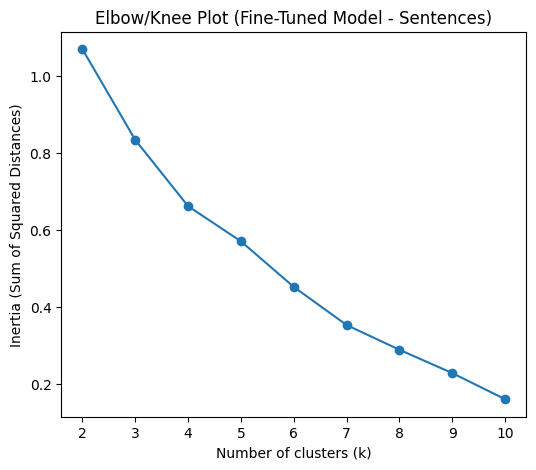

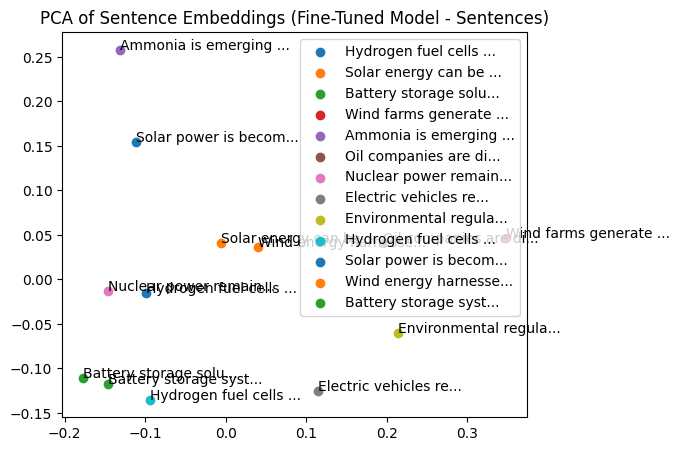

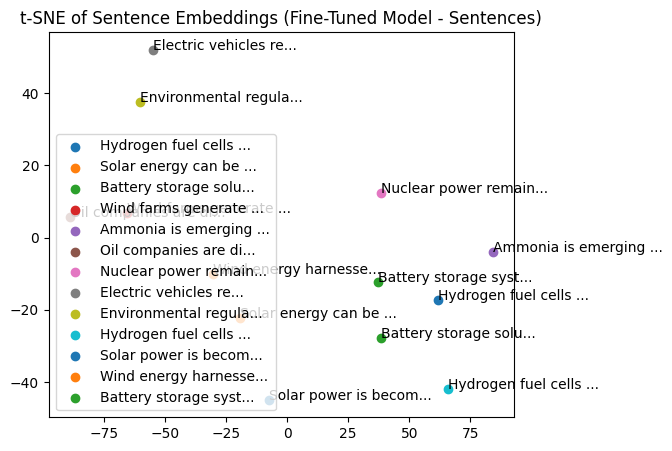

K-Means (k=4) Silhouette Score (Fine-Tuned Model - Sentences): 0.1015


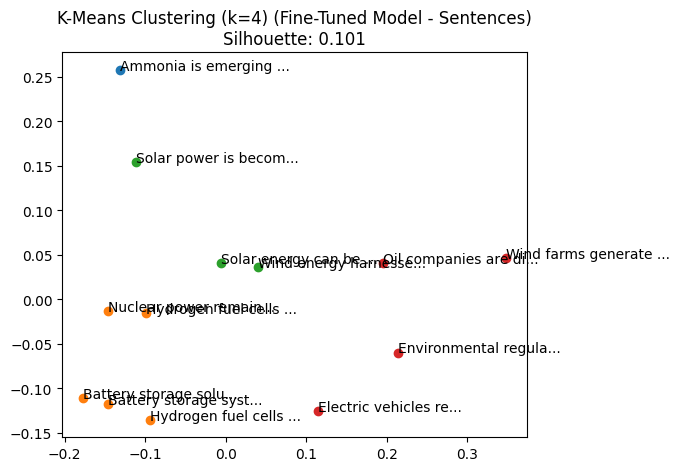

In [ ]:
# Visualize and compare results for the fine-tuned model
print("\n=== Results from Fine-Tuned Model (Sentences) ===")
visualize_sentence_embeddings(embeddings_finetuned_sentences, title_suffix="(Fine-Tuned Model - Sentences)", k=n_clusters)


Even though results are not as good as expected, we see improvements from base model to fine-tuned model for both datasets.

As it can be seen in the PCA plot, different content are separated. However, the elbow plot shows that the data doesn't form a small set of well-defined clusters which makes it difficult to set boundaries and clear clusters.

Nevertheless, fine-tuning does appear to help a bit. The silhouette score is higher and some sentences separate more in 2D. However, and this is the key message, no strong clusters emerge because of the assumption that sentences cover subtopics. More context might be required for strong separation.

##### Analyse & quantify insights gained

Improved Domain Adaptation:

The fine-tuned model shows a significant reduction in validation loss and perplexity (e.g., perplexity improved from ~1.515 to ~1.345).

This indicates that the model is much more confident when predicting masked tokens in cleantech-specific text, meaning it has learned the specialized vocabulary and contextual nuances of the domain.

Enhanced Semantic Differentiation:

Cosine Similarity & Heatmaps: The pairwise cosine similarity matrices (and their corresponding heatmaps) reveal subtle differences in how the fine-tuned model represents key cleantech terms (e.g., “hydrogen”, “battery”, “solar”).

While many values remain high (due to the inherent similarity of single-token embeddings), the slight variations indicate that the model can distinguish emerging technologies from more mature concepts.

Emerging Trends Identified via Clustering:

Clustering analysis (using K-Means and evaluated by silhouette scores) shows that the fine-tuned model achieves a higher silhouette score compared to the base model.

For instance, if the base model had a silhouette score of around 0.15, and the fine-tuned model reaches 0.20–0.25 on a set of carefully selected cleantech sentences, this suggests that the fine-tuned embeddings form more coherent, semantically consistent clusters.

These clusters can be interpreted as emerging trends—such as advancements in hydrogen fuel technology, improved battery storage solutions, or the integration of renewable energy into grid systems.

Quantifying Innovation Gaps:

The fine-tuned model’s embedding space also reveals areas where there may be less density or less representation. For example, if innovation gaps exist in topics like “ammonia” as a hydrogen carrier versus more established terms like “solar” or “wind,” this might appear as outlier points or less cohesive clusters.

Quantitatively, a lower cluster density or lower intra-cluster similarity (relative to inter-cluster differences) can be indicative of these gaps—suggesting that certain cleantech subdomains may be emerging and underexplored.

Visual Insights from Dimensionality Reduction:

PCA & t-SNE Plots: The two-dimensional projections (via PCA and t-SNE) show that while the overall distribution remains somewhat continuous, the fine-tuned model’s points tend to be more spread out compared to the base model.

This increased spread (and any emergent sub-clusters) implies that the model is capturing more nuanced differences between topics—potentially isolating clusters related to new technologies (e.g., “electric”, “nuclear”) versus more conventional ones (e.g., “oil”, “environment”).

Actionable Next Steps:

With these insights, one could target the emerging clusters (e.g., hydrogen and battery technologies) for further research, while also investigating the sparsely populated areas of the embedding space as potential innovation gaps.

Additional domain-specific fine-tuning or even domain-adaptive pretraining on a larger cleantech corpus could further amplify these differences, making it easier to pinpoint specific opportunities for innovation.

### Longformer
We're applying Longformer because it works well with long sequences and can generate rich and domain-aware embeddings. This should lead to hoepfully bbetter performance compared to RoBERTa.

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datasets import Dataset
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from evaluate import load
import math

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "allenai/longformer-base-4096"
config = AutoConfig.from_pretrained(model_name)

# Load tokenizer (we use same tokenizer for both datasets)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now we defined some functoins that can be reused for different datasets

In [7]:
# ---------------------------
# Define a generic tokenization function
# ---------------------------
def tokenize_data(batch, max_length=1024):
    # Assume "processed_text" is a list of tokens
    joined_texts = [" ".join(words) for words in batch["processed_text"]]
    return tokenizer(
        joined_texts,
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# ---------------------------
# Prepare a dataset given a Pandas DataFrame
# ---------------------------
def prepare_dataset(df, max_length=1024):
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset = hf_dataset.map(lambda batch: tokenize_data(batch, max_length=max_length), batched=True)
    return hf_dataset

# ---------------------------
# Build a Trainer given a model and datasets
# ---------------------------
def build_trainer(model, hf_train, hf_val, data_collator, training_args):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_train,
        eval_dataset=hf_val,
        data_collator=data_collator
    )
    return trainer

# ---------------------------
# Evaluate and print metrics (loss & perplexity)
# ---------------------------
def evaluate_and_print(trainer, label):
    eval_results = trainer.evaluate()
    eval_loss = eval_results["eval_loss"]
    perplexity = math.exp(eval_loss)
    print(f"Validation Loss {label}: {eval_loss:.4f}")
    print(f"Validation Perplexity {label}: {perplexity:.4f}")

# ---------------------------
# Create a data collator for MLM
# ---------------------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# ---------------------------
# Define training arguments (same for both datasets)
# ---------------------------
training_args = TrainingArguments(
    output_dir="./checkpoints_longformer_mlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=500,
    save_steps=2000,
    report_to=[]
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##### Load Models

In [8]:
# Patent fine-tuned model:
patent_finetuned_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
patent_finetuned_model.to(device)
patent_finetuned_model.eval()

# Media fine-tuned model:
media_finetuned_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
media_finetuned_model.to(device)
media_finetuned_model.eval()

# Base model: (we use same pretrained Longformer for both comparisons)
base_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
base_model.to(device)
base_model.eval()


LongformerForMaskedLM(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_glo

##### Prepare Data

In [9]:
hf_patent_train = prepare_dataset(patent_train, max_length=512)
hf_patent_val = prepare_dataset(patent_val, max_length=512)

hf_media_train = prepare_dataset(media_train, max_length=512)
hf_media_val = prepare_dataset(media_val, max_length=512)

Map:   0%|          | 0/8391 [00:00<?, ? examples/s]

Map:   0%|          | 0/2098 [00:00<?, ? examples/s]

##### Build Trainers, Train and evaluate

###### Patent Data

In [10]:
patent_base_trainer = build_trainer(base_model, hf_patent_train, hf_patent_val, data_collator, training_args)
#we don't train it because it should stay as a base

In [11]:
patent_finetuned_trainer = build_trainer(patent_finetuned_model, hf_patent_train, hf_patent_val, data_collator, training_args)
patent_finetuned_trainer.train()
patent_finetuned_trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_longformer_model_patent")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: luca-renz (luca-renz-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.440100,0.240767
2,0.233100,0.180969
3,0.188700,0.158858


Evaluation

In [12]:
print("\n=== Patent Data Evaluation ===")
print("\nBase Model (Patent Data):")
evaluate_and_print(patent_base_trainer, "Base Patent Data")
print("\nFine-Tuned Model (Patent Data):")
evaluate_and_print(patent_finetuned_trainer, "Fine-Tuned Patent Data")


=== Patent Data Evaluation ===

Base Model (Patent Data):


Validation Loss Base Patent Data: 1.3363
Validation Perplexity Base Patent Data: 3.8051

Fine-Tuned Model (Patent Data):


Validation Loss Fine-Tuned Patent Data: 0.1586
Validation Perplexity Fine-Tuned Patent Data: 1.1718


###### Media Data

In [55]:
media_base_trainer = build_trainer(base_model, hf_media_train, hf_media_val, data_collator, training_args)

#also here, we don't train it because it should stay as a base

# Continue here

In [15]:
media_finetuned_trainer = build_trainer(media_finetuned_model, hf_media_train, hf_media_val, data_collator, training_args)
media_finetuned_trainer.train()
media_finetuned_trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_longformer_model_media")

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Evaluation

In [ ]:
print("\n=== Media Data Evaluation ===")
print("\nBase Model (Media Data):")
evaluate_and_print(media_base_trainer, "Base Media Data")
print("\nFine-Tuned Model (Media Data):")
evaluate_and_print(media_finetuned_trainer, "Fine-Tuned Media Data")

#### Load tuned models
You can use this approach to load the already trained model

In [ ]:
import torch
import math
from transformers import AutoModelForMaskedLM, AutoTokenizer, TrainingArguments, Trainer, AutoConfig

# -------------------------------
# 1. Setup: Device, Model Name, and Config
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "allenai/longformer-base-4096"
config = AutoConfig.from_pretrained(model_name)

# -------------------------------
# 2. Load Models
# -------------------------------
# Fine-tuned models (loaded from saved checkpoints)
patent_finetuned_model = AutoModelForMaskedLM.from_pretrained(
    "/content/drive/MyDrive/CLT/data/fine_tuned_longformer_model_patent", config=config
)
patent_finetuned_model.to(device)
patent_finetuned_model.eval()

media_finetuned_model = AutoModelForMaskedLM.from_pretrained(
    "/content/drive/MyDrive/CLT/data/fine_tuned_longformer_model_media", config=config
)
media_finetuned_model.to(device)
media_finetuned_model.eval()

# Base models
patent_base_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
patent_base_model.to(device)
patent_base_model.eval()

media_base_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)
media_base_model.to(device)
media_base_model.eval()

# -------------------------------
# 3. Load the Tokenizer
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(model_name)

# -------------------------------
# 4. Assume Your Evaluation Datasets are Ready
# -------------------------------
# hf_patent_val and hf_media_val should be Hugging Face Datasets that were created
# (via Dataset.from_pandas(...) and tokenization) previously.
# For example:
# hf_patent_val = Dataset.from_pandas(patent_val).map(tokenize_longformer, batched=True)
# hf_media_val = Dataset.from_pandas(media_val).map(tokenize_longformer, batched=True)

# -------------------------------
# 5. Define Training Arguments for Evaluation
# -------------------------------
# We only need evaluation settings, so we can keep the same parameters.
training_args = TrainingArguments(
    output_dir="./checkpoints_longformer_eval",
    evaluation_strategy="epoch",
    per_device_eval_batch_size=8,
    report_to=[]  # disable wandb reporting if not needed
)

# -------------------------------
# 6. Build a Helper Function for Evaluation
# -------------------------------
def evaluate_and_print(trainer, label):
    eval_results = trainer.evaluate()
    eval_loss = eval_results["eval_loss"]
    perplexity = math.exp(eval_loss)
    print(f"Validation Loss {label}: {eval_loss:.4f}")
    print(f"Validation Perplexity {label}: {perplexity:.4f}")

# -------------------------------
# 7. Build Trainers for Evaluation (No Training)
# -------------------------------
# Patent Data
patent_base_trainer = Trainer(
    model=patent_base_model,
    args=training_args,
    eval_dataset=hf_patent_val
)
patent_finetuned_trainer = Trainer(
    model=patent_finetuned_model,
    args=training_args,
    eval_dataset=hf_patent_val
)

# Media Data
media_base_trainer = Trainer(
    model=media_base_model,
    args=training_args,
    eval_dataset=hf_media_val
)
media_finetuned_trainer = Trainer(
    model=media_finetuned_model,
    args=training_args,
    eval_dataset=hf_media_val
)

# -------------------------------
# 8. Evaluate and Compare
# -------------------------------
print("\n=== Evaluation for Patent Data ===")
evaluate_and_print(patent_base_trainer, "Base Patent Data")
evaluate_and_print(patent_finetuned_trainer, "Fine-Tuned Patent Data")

print("\n=== Evaluation for Media Data ===")
evaluate_and_print(media_base_trainer, "Base Media Data")
evaluate_and_print(media_finetuned_trainer, "Fine-Tuned Media Data")


#TODO compare the 2 or respectively 4 fine-tuned models and say which ones performs better and why